<a href="https://colab.research.google.com/github/mavillan/gb-vpp/blob/main/models/gb-vpp-lstm-gru-stk-lvl1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

!pip install --upgrade kaggle > /dev/null 2>&1
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
import tensorflow as tf

if tf.__version__ != '2.4.3':
    !pip uninstall -y tensorflow 
    !pip install tensorflow==2.4.3 > /dev/null 2>&1
!pip install tensorflow-addons > /dev/null 2>&1
!pip install --upgrade pandas > /dev/null 2>&1

print("Tensorflow version " + tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

import os
from tensorflow.python.profiler import profiler_client
#tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
#print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

Tensorflow version 2.4.3
INFO:tensorflow:Initializing the TPU system: grpc://10.119.142.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.142.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.119.142.90:8470']


In [3]:
!mkdir -p input/
!kaggle competitions download -c ventilator-pressure-prediction -p input/ --force

!unzip -o input/sample_submission.csv.zip -d input/
!unzip -o input/train.csv.zip -d input/
!unzip -o input/test.csv.zip -d input/

  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 78.7MB/s]
 98% 74.0M/75.4M [00:00<00:00, 182MB/s]
100% 75.4M/75.4M [00:00<00:00, 169MB/s]
 90% 125M/139M [00:00<00:00, 160MB/s]
100% 139M/139M [00:01<00:00, 142MB/s]
Archive:  input/sample_submission.csv.zip
  inflating: input/sample_submission.csv  
Archive:  input/train.csv.zip
  inflating: input/train.csv         
Archive:  input/test.csv.zip
  inflating: input/test.csv          


In [4]:
input_path = "input"
subs_path = "/content/drive/MyDrive/kaggle/gb-vpp/subs"
results_path = "/content/drive/MyDrive/kaggle/gb-vpp/results"
artifacts_path = "/content/drive/MyDrive/kaggle/gb-vpp/artifacts"

In [5]:
!kaggle datasets download --unzip --force -d mavillan/gb-vpp-folds-split
#!kaggle datasets download --unzip --force -d markpeng/lightning-unsupervised-tst

 87% 10.0M/11.5M [00:00<00:00, 99.6MB/s]
100% 11.5M/11.5M [00:00<00:00, 104MB/s] 


In [6]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        714M        4.5G        1.1M        7.5G         11G
Swap:            0B          0B          0B


***

In [7]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

import sys
sys.path.append("/content/drive/MyDrive/kaggle")
from gauss_rank_scaler import GaussRankScaler

In [8]:
def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

***
## data preparation

In [9]:
class config:
    # data params
    SEQ_LEN = 32

    # train params
    EPOCHS = 300
    BATCH_SIZE = 512
    # for ReduceLROnPlateu
    SCHEDULER_PATIENCE = 10
    SCHEDULER_FACTOR = 0.8
    STOPPING_PATIENCE = 35
    # for cyclical schedulers
    INIT_LR = 1e-4
    MAX_LR = 1e-3
    
    # others
    MODEL_ID = "lstm-gru-stk-lvl1"
    DEBUG = False
    
if config.DEBUG:
    config.EPOCHS = 2

In [10]:
with open("./split_10folds_seed23.pkl", "rb") as file:
    split = pickle.load(file)

In [11]:
train_raw = reduce_mem_usage(pd.read_csv(f'{input_path}/train.csv'), verbose=True)
test_raw = reduce_mem_usage(pd.read_csv(f'{input_path}/test.csv'), verbose=True)
submission = pd.read_csv(f'{input_path}/sample_submission.csv')

gc.collect()

Mem. usage decreased to 132.40 Mb (64.1% reduction)
Mem. usage decreased to 72.91 Mb (66.1% reduction)


22

In [12]:
PRESSURE_VALUES = np.sort(train_raw.pressure.unique())

PRESSURE_MIN = train_raw.pressure.min()
PRESSURE_MAX = train_raw.pressure.max()
PRESSURE_STEP = PRESSURE_VALUES[1]-PRESSURE_VALUES[0]

def discretize_pressure(pressure_array):
    pressure_array = np.clip(pressure_array, PRESSURE_MIN, PRESSURE_MAX)
    discrete = np.round( (pressure_array - PRESSURE_MIN)/PRESSURE_STEP ) * PRESSURE_STEP + PRESSURE_MIN
    return discrete

def pressure_to_idx(array):
    return ((array - PRESSURE_MIN) / PRESSURE_STEP).astype(int)

def idx_to_pressure(array):
    return (array * PRESSURE_STEP) + PRESSURE_MIN

In [14]:
# load oof preds
oof1 = pd.read_csv(f"{results_path}/oof_lstm-gru-2h.csv")[["id","pred"]].rename({"pred":"pred1"}, axis=1)
oof1["pred1"] = discretize_pressure(oof1.pred1.values)

oof2 = pd.read_csv(f"{results_path}/oof_lstm-gru-tangle-2h.csv")[["id","pred"]].rename({"pred":"pred2"}, axis=1)
oof2["pred2"] = discretize_pressure(oof2.pred2.values)

# load model preds (8 folds)
sub1 = pd.read_csv(f"{subs_path}/sub_lstm-gru-2h_clip.csv").rename({"pressure":"pred1"}, axis=1)
sub2 = pd.read_csv(f"{subs_path}/sub_lstm-gru-tangle-2h_clip.csv").rename({"pressure":"pred2"}, axis=1)

In [15]:
assert (train_raw.id == oof1.id).all()
assert (train_raw.id == oof2.id).all()
train_raw["pred1"] = oof1["pred1"].values
train_raw["pred2"] = oof2["pred2"].values

assert (test_raw.id == sub1.id).all()
assert (test_raw.id == sub2.id).all()
test_raw["pred1"] = sub1["pred1"].values
test_raw["pred2"] = sub2["pred2"].values

In [16]:
mapping = {j:i for i,j in enumerate(train_raw.breath_id.unique())}
train_raw["breath_id"] = train_raw.breath_id.map(mapping)

if config.SEQ_LEN < 80:

    train_raw = (
        train_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(config.SEQ_LEN)
        .reset_index(drop=True)
    )
    test_raw = (
        test_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(config.SEQ_LEN)
        .reset_index(drop=True)
    )

In [17]:
def compute_feats(df):

    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] = df['u_in_cumsum'] / (df.groupby("breath_id")["id"].cumcount()+1)
    df['u_in_max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['u_in_diffmax'] = df["u_in_max"] - df['u_in']

    df["time_diff"] = df.groupby("breath_id")["time_step"].diff()
    df['vol_diff'] = (df['time_diff']*df['u_in']).fillna(0)
    df['vol_diff_cumsum'] = df.groupby('breath_id')['vol_diff'].cumsum()
    df["time_diff"] = df["time_diff"].fillna(method="bfill")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_in_lag5'] = df.groupby('breath_id')['u_in'].shift(5)
    df['u_in_lag6'] = df.groupby('breath_id')['u_in'].shift(6)
    df['u_in_lag7'] = df.groupby('breath_id')['u_in'].shift(7)
    df['u_in_lag8'] = df.groupby('breath_id')['u_in'].shift(8)
    df['u_in_lag9'] = df.groupby('breath_id')['u_in'].shift(9)
    df['u_in_lag10'] = df.groupby('breath_id')['u_in'].shift(10)
    df = df.fillna(0)

    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_in_diff5'] = df['u_in'] - df['u_in_lag5']
    df['u_in_diff6'] = df['u_in'] - df['u_in_lag6']
    df['u_in_diff7'] = df['u_in'] - df['u_in_lag7']
    df['u_in_diff8'] = df['u_in'] - df['u_in_lag8']
    df['u_in_diff9'] = df['u_in'] - df['u_in_lag9']
    df['u_in_diff10'] = df['u_in'] - df['u_in_lag10']

    df['ewm_u_in_mean'] = (
        df
        .groupby('breath_id')['u_in']
        .ewm(halflife=9)
        .mean()
        .reset_index(level=0,drop=True)
    )

    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df = pd.get_dummies(df)
    
    return df

print("Train data...\n")
train = compute_feats(train_raw)
train = reduce_mem_usage(train, verbose=True)
print("\nTest data...\n")
test = compute_feats(test_raw)
test = reduce_mem_usage(test, verbose=True)

del train_raw,test_raw
gc.collect()

Train data...

Mem. usage decreased to 338.48 Mb (9.8% reduction)

Test data...

Mem. usage decreased to 219.51 Mb (7.7% reduction)


0

In [18]:
targets = train[['pressure']].to_numpy().reshape(-1, config.SEQ_LEN)
mask_out = train[["u_out"]].to_numpy().reshape(-1, config.SEQ_LEN)
mask_in = 1-mask_out

oof = train[["id","breath_id","u_out","pressure"]].copy()
test_raw = test[["id"]].copy()

cols_to_exclude_train = [
    'pressure','id', 'breath_id', 'u_out'
]
cols_to_exclude_test = [
    'id', 'breath_id', 'u_out'
]

train.drop(cols_to_exclude_train, axis=1, inplace=True)
test.drop(cols_to_exclude_test, axis=1, inplace=True)

train.insert(0, "u_in", train.pop("u_in").values)
test.insert(0, "u_in", test.pop("u_in").values)

assert (train.columns == test.columns).all()

In [19]:
categorical_cols = [
    "R_5","R_20","R_50",
    "C_10","C_20","C_50",
]
numerical_cols = list(set(train.columns) - set(categorical_cols))

In [20]:
merged = pd.concat([train[numerical_cols], test[numerical_cols]], axis=0, ignore_index=True)

scaler = RobustScaler()
#scaler = GaussRankScaler()
scaler.fit(merged.values)

train[numerical_cols] = scaler.transform(train[numerical_cols].values)
test[numerical_cols] = scaler.transform(test[numerical_cols].values)

In [21]:
train = train.values.reshape(-1, config.SEQ_LEN, train.shape[1])
test =  test.values.reshape(-1, config.SEQ_LEN, train.shape[2])

***

In [22]:
def masked_l1_loss(y_true, y_pred, mask):
    return tf.keras.losses.mae(tf.boolean_mask(y_true, mask), tf.boolean_mask(y_pred, mask))

class LSTMGRU2Heads(tf.keras.Model):

    def __init__(self):
        super(LSTMGRU2Heads, self).__init__()

        self.noise_level = 1.0

        # feature extrators on u_in
        self.conv1 = layers.Conv1D(32, 5, padding="same", activation='tanh')
        
        self.lstm1 = layers.Bidirectional(layers.LSTM(units=768, return_sequences=True, recurrent_dropout=0.))
        self.lstm2 = layers.Bidirectional(layers.LSTM(units=512, return_sequences=True, recurrent_dropout=0.))
        self.lstm3 = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True, recurrent_dropout=0.))
        self.lstm4 = layers.Bidirectional(layers.LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))

        self.gru1 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, recurrent_dropout=0.1))
        self.gru2 = layers.Bidirectional(layers.GRU(units=128, return_sequences=True, recurrent_dropout=0.1))
        self.gru3 = layers.Bidirectional(layers.GRU(units=64, return_sequences=True,  recurrent_dropout=0.1))

        self.dense1 = tfa.layers.WeightNormalization(layers.Dense(units=128, activation='selu',))
        self.head1 = tfa.layers.WeightNormalization(layers.Dense(units=1))
        
        self.tracker_loss = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        
        # features extracted over u_in with conv layers
        u_in = tf.expand_dims(inputs[:,:,0], axis=-1)
        u_in_k5 = self.conv1(u_in)

        x = tf.concat([inputs, u_in_k5], axis=-1)

        x1 = self.lstm1(x)
        x2 = self.lstm2(x1)
        x3 = self.lstm3(x2)
        x4 = self.lstm4(x3)
        
        z2 = self.gru1(x2)
        z3 = self.gru2(x3+z2)
        z4 = self.gru3(x4+z3)
        
        x = tf.concat([x4, z2, z3, z4], axis=-1)
        x = self.dense1(x)
        
        output_in = self.head1(x)
        return output_in

    def train_step(self, data):
        X,y = data
        x,mask_in,_ = X

        with tf.GradientTape() as tape:
            y_pred_in = self(x, training=True)
            y_pred_in = tf.squeeze(y_pred_in)
            # compute the loss value
            noise = tf.random.truncated_normal(
                tf.shape(y), 
                mean=0.0, 
                stddev=self.noise_level*PRESSURE_STEP, 
                dtype=tf.dtypes.float32, 
                seed=2,
              )
            loss_l1 = masked_l1_loss(y+noise, y_pred_in, mask_in)
            loss_reg = tf.math.reduce_sum(self.losses)
            loss = loss_l1 + loss_reg

        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # update metrics (includes the metric that tracks the loss)
        self.tracker_loss.update_state(loss)

        return {
            "loss": self.tracker_loss.result(), 
        }

    @property
    def metrics(self):
        return [self.tracker_loss,]

    def test_step(self, data):
        X,y = data
        x,mask_in,_ = X
        # compute predictions
        y_pred_in = self(x, training=False)
        y_pred_in = tf.squeeze(y_pred_in)
        # compute loss
        loss = masked_l1_loss(y, y_pred_in, mask_in)
        # updates the metrics
        self.tracker_loss.update_state(loss)
        
        return {
            "loss": self.tracker_loss.result(),
        }

    def predict_step(self, data):
        y_pred_in = self(data, training=False)
        return y_pred_in

----------------------------------- Fold: 1 ------------------------------------
Epoch 1/300
133/133 [==============================] - 121s 371ms/step - loss: 1.9752 - val_loss: 0.7118
Epoch 2/300
133/133 [==============================] - 13s 96ms/step - loss: 0.7201 - val_loss: 0.8418
Epoch 3/300
133/133 [==============================] - 13s 96ms/step - loss: 0.6515 - val_loss: 0.4619
Epoch 4/300
133/133 [==============================] - 13s 97ms/step - loss: 0.5672 - val_loss: 0.4854
Epoch 5/300
133/133 [==============================] - 13s 96ms/step - loss: 0.5328 - val_loss: 0.8456
Epoch 6/300
133/133 [==============================] - 13s 96ms/step - loss: 0.5204 - val_loss: 0.3869
Epoch 7/300
133/133 [==============================] - 13s 96ms/step - loss: 0.4104 - val_loss: 0.4499
Epoch 8/300
133/133 [==============================] - 13s 96ms/step - loss: 0.4125 - val_loss: 0.3561
Epoch 9/300
133/133 [==============================] - 13s 97ms/step - loss: 0.4562 - val_los

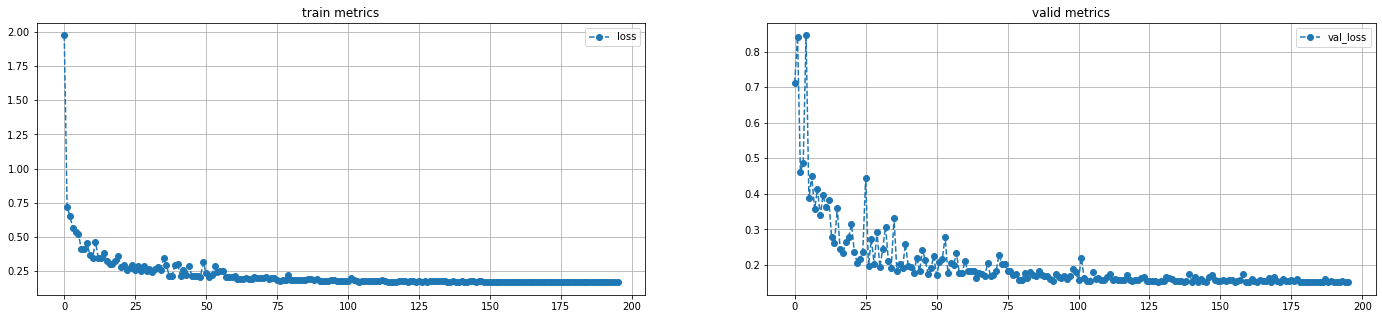

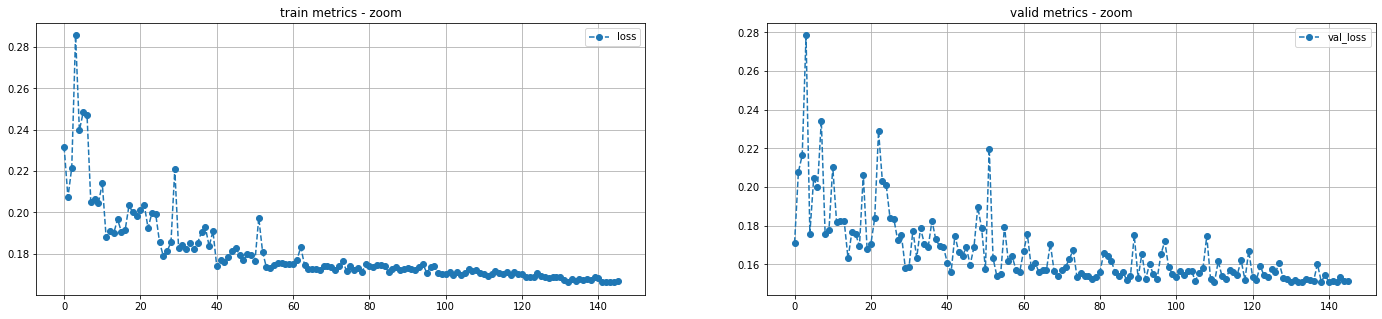

----------------------------------- Fold: 2 ------------------------------------
Epoch 1/300
133/133 [==============================] - 101s 372ms/step - loss: 2.0638 - val_loss: 0.9658
Epoch 2/300
133/133 [==============================] - 13s 100ms/step - loss: 0.8412 - val_loss: 0.7420
Epoch 3/300
133/133 [==============================] - 13s 99ms/step - loss: 0.6509 - val_loss: 0.5048
Epoch 4/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5125 - val_loss: 0.3983
Epoch 5/300
133/133 [==============================] - 13s 99ms/step - loss: 0.4469 - val_loss: 0.3249
Epoch 6/300
133/133 [==============================] - 13s 99ms/step - loss: 0.4121 - val_loss: 0.4399
Epoch 7/300
133/133 [==============================] - 13s 99ms/step - loss: 0.3611 - val_loss: 0.2774
Epoch 8/300
133/133 [==============================] - 13s 100ms/step - loss: 0.3229 - val_loss: 0.2945
Epoch 9/300
133/133 [==============================] - 13s 99ms/step - loss: 0.3335 - val_l

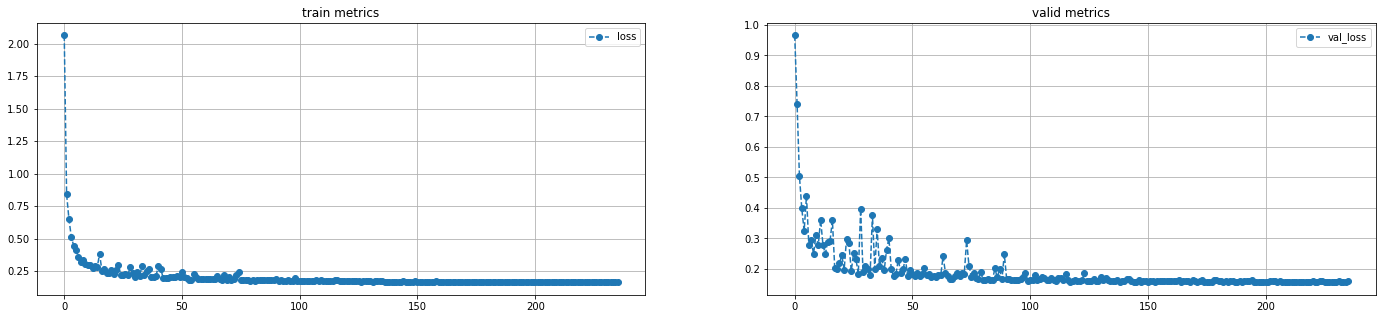

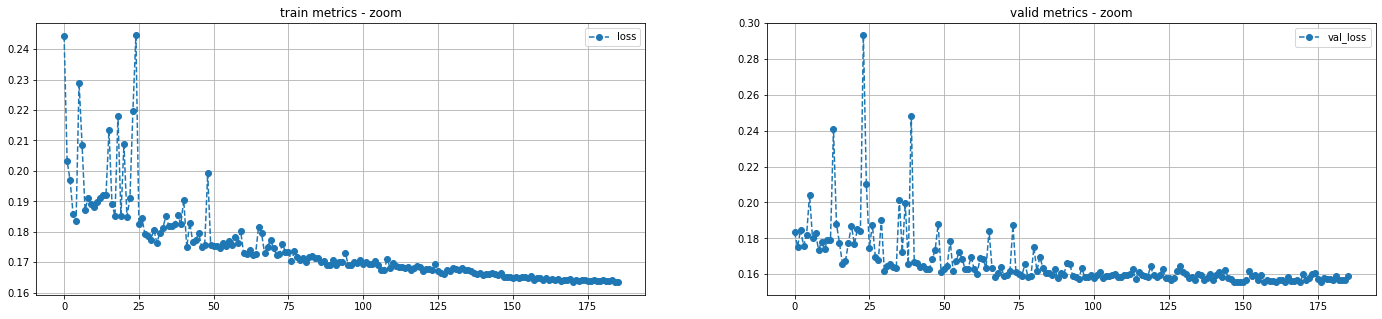

----------------------------------- Fold: 3 ------------------------------------
Epoch 1/300
133/133 [==============================] - 103s 371ms/step - loss: 2.1256 - val_loss: 0.7205
Epoch 2/300
133/133 [==============================] - 13s 99ms/step - loss: 0.7354 - val_loss: 0.4866
Epoch 3/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5183 - val_loss: 0.5038
Epoch 4/300
133/133 [==============================] - 13s 100ms/step - loss: 0.5243 - val_loss: 0.4930
Epoch 5/300
133/133 [==============================] - 13s 100ms/step - loss: 0.4043 - val_loss: 0.3783
Epoch 6/300
133/133 [==============================] - 13s 99ms/step - loss: 0.4108 - val_loss: 0.3642
Epoch 7/300
133/133 [==============================] - 13s 99ms/step - loss: 0.3289 - val_loss: 0.2624
Epoch 8/300
133/133 [==============================] - 13s 99ms/step - loss: 0.3237 - val_loss: 0.3819
Epoch 9/300
133/133 [==============================] - 13s 99ms/step - loss: 0.3065 - val_l

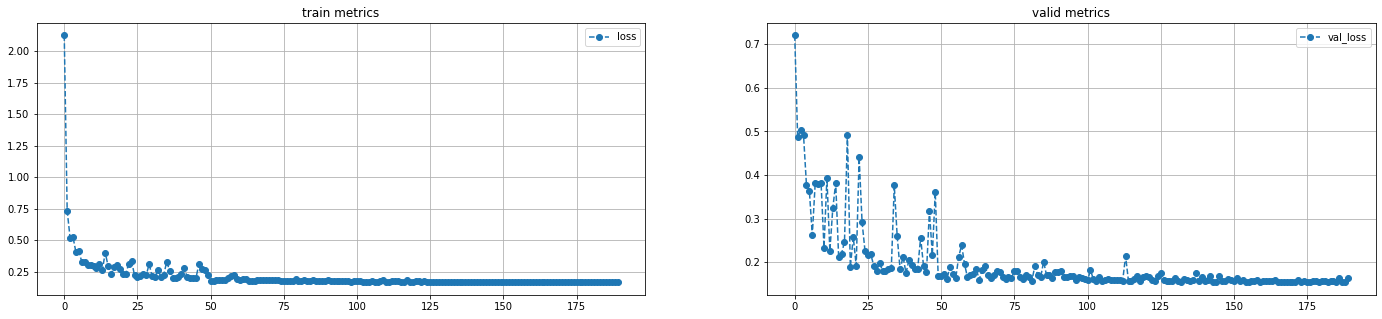

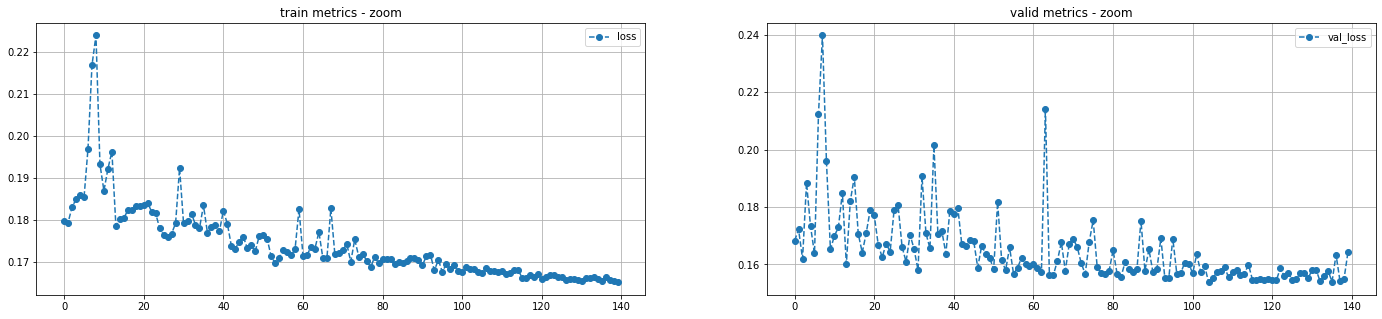

----------------------------------- Fold: 4 ------------------------------------
Epoch 1/300
133/133 [==============================] - 101s 370ms/step - loss: 2.0649 - val_loss: 0.9792
Epoch 2/300
133/133 [==============================] - 13s 99ms/step - loss: 0.8998 - val_loss: 0.8296
Epoch 3/300
133/133 [==============================] - 13s 99ms/step - loss: 0.7053 - val_loss: 0.5950
Epoch 4/300
133/133 [==============================] - 13s 99ms/step - loss: 0.6533 - val_loss: 0.5308
Epoch 5/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5200 - val_loss: 0.4670
Epoch 6/300
133/133 [==============================] - 13s 99ms/step - loss: 0.4566 - val_loss: 0.4516
Epoch 7/300
133/133 [==============================] - 13s 99ms/step - loss: 0.4098 - val_loss: 0.3902
Epoch 8/300
133/133 [==============================] - 13s 99ms/step - loss: 0.3910 - val_loss: 0.3267
Epoch 9/300
133/133 [==============================] - 13s 99ms/step - loss: 0.3531 - val_los

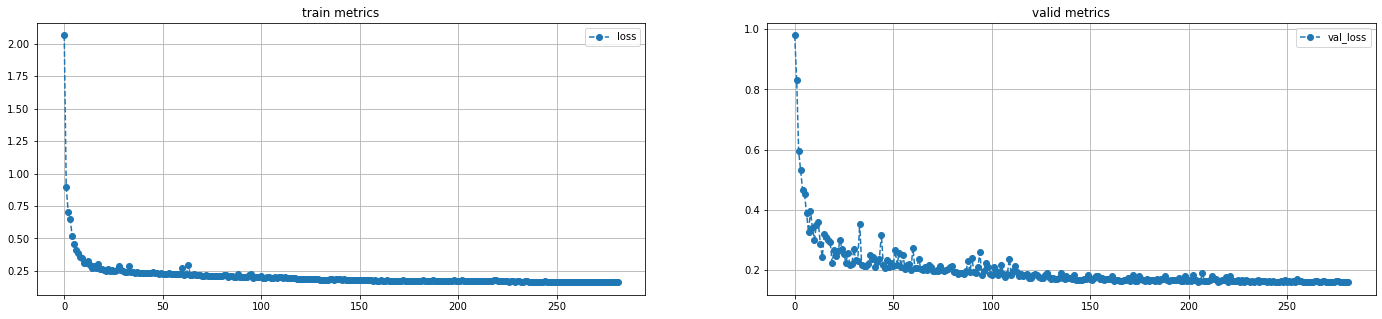

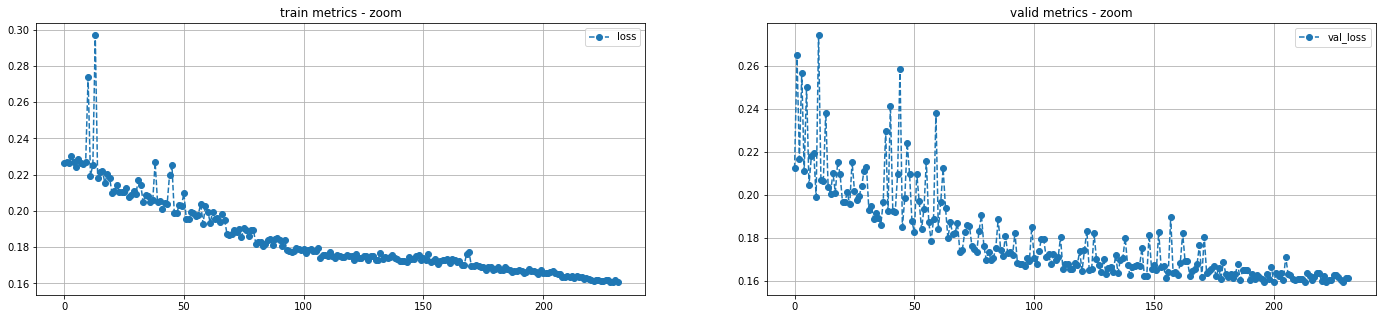

----------------------------------- Fold: 5 ------------------------------------
Epoch 1/300
133/133 [==============================] - 101s 371ms/step - loss: 2.2280 - val_loss: 1.0171
Epoch 2/300
133/133 [==============================] - 13s 99ms/step - loss: 0.8901 - val_loss: 0.9362
Epoch 3/300
133/133 [==============================] - 13s 100ms/step - loss: 0.7323 - val_loss: 0.8651
Epoch 4/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5886 - val_loss: 0.6044
Epoch 5/300
133/133 [==============================] - 13s 100ms/step - loss: 0.5328 - val_loss: 0.4110
Epoch 6/300
133/133 [==============================] - 13s 99ms/step - loss: 0.4751 - val_loss: 0.5594
Epoch 7/300
133/133 [==============================] - 13s 100ms/step - loss: 0.5144 - val_loss: 0.3946
Epoch 8/300
133/133 [==============================] - 13s 100ms/step - loss: 0.4081 - val_loss: 0.4718
Epoch 9/300
133/133 [==============================] - 13s 100ms/step - loss: 0.3891 - va

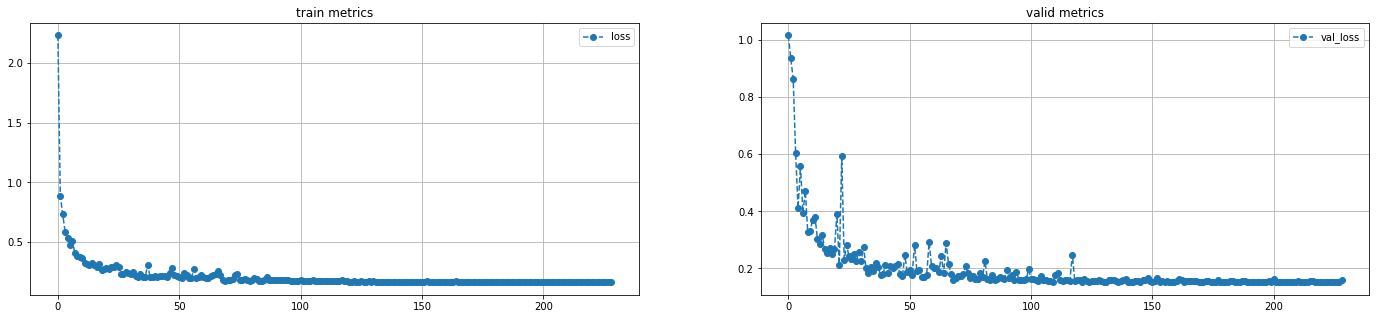

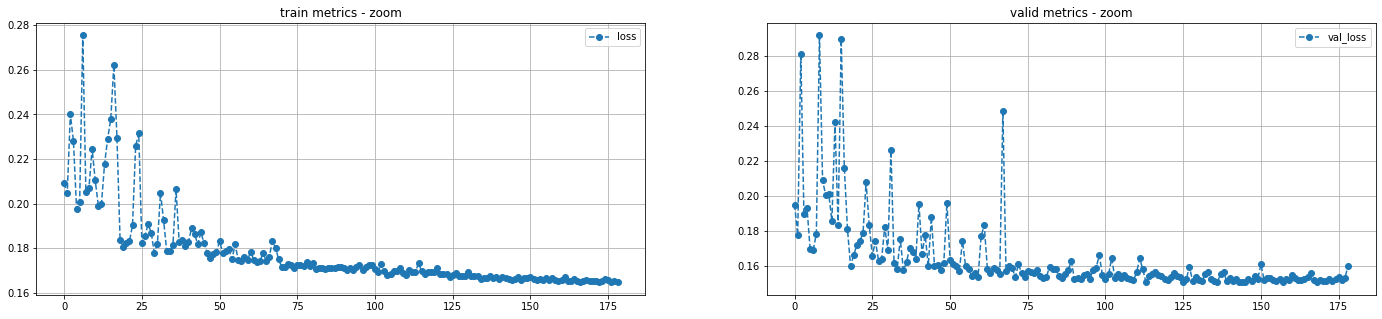

----------------------------------- Fold: 6 ------------------------------------
Epoch 1/300
133/133 [==============================] - 98s 368ms/step - loss: 2.1598 - val_loss: 1.1964
Epoch 2/300
133/133 [==============================] - 13s 98ms/step - loss: 0.8856 - val_loss: 0.7605
Epoch 3/300
133/133 [==============================] - 13s 99ms/step - loss: 0.6938 - val_loss: 0.6723
Epoch 4/300
133/133 [==============================] - 13s 99ms/step - loss: 0.6630 - val_loss: 0.5571
Epoch 5/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5858 - val_loss: 0.5770
Epoch 6/300
133/133 [==============================] - 13s 100ms/step - loss: 0.5663 - val_loss: 0.5105
Epoch 7/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5332 - val_loss: 0.5374
Epoch 8/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5355 - val_loss: 0.4998
Epoch 9/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5204 - val_los

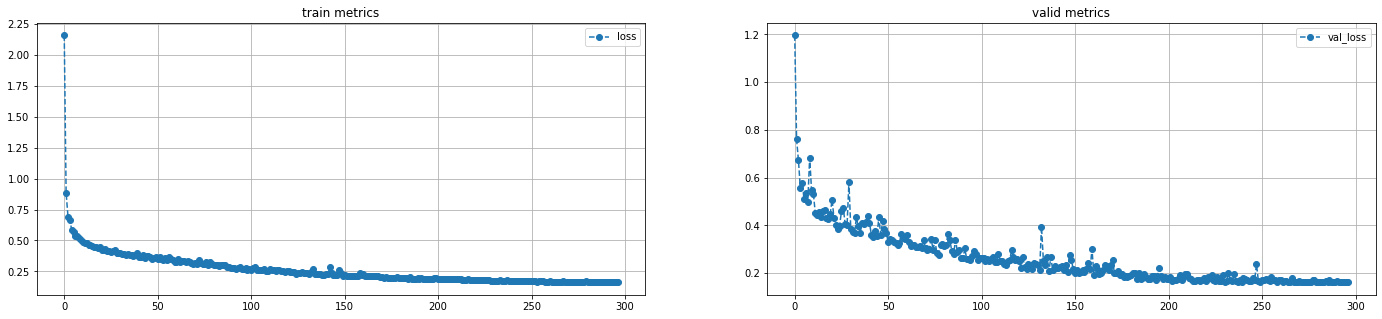

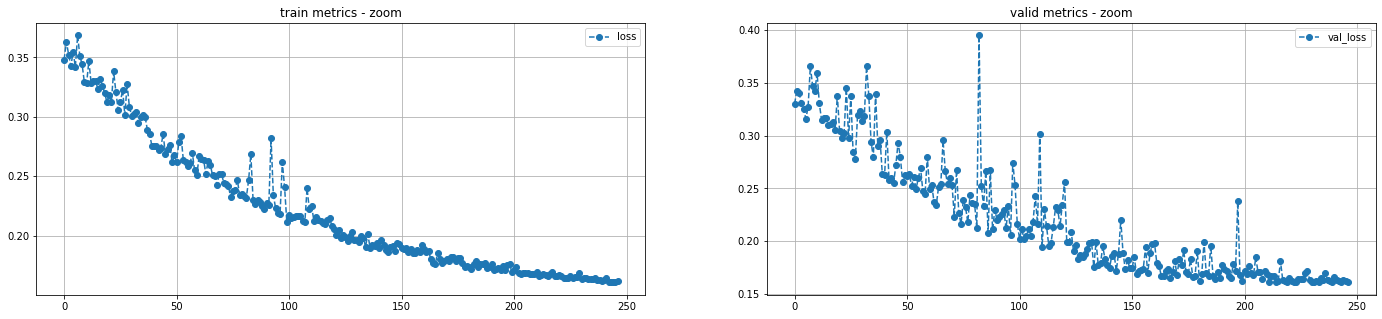

----------------------------------- Fold: 7 ------------------------------------
Epoch 1/300
133/133 [==============================] - 102s 391ms/step - loss: 2.2016 - val_loss: 0.9547
Epoch 2/300
133/133 [==============================] - 13s 98ms/step - loss: 0.9196 - val_loss: 0.9665
Epoch 3/300
133/133 [==============================] - 13s 99ms/step - loss: 0.7203 - val_loss: 0.7068
Epoch 4/300
133/133 [==============================] - 13s 98ms/step - loss: 0.6331 - val_loss: 0.5403
Epoch 5/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5627 - val_loss: 0.5256
Epoch 6/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5467 - val_loss: 0.5439
Epoch 7/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5021 - val_loss: 0.4123
Epoch 8/300
133/133 [==============================] - 13s 99ms/step - loss: 0.4675 - val_loss: 0.3751
Epoch 9/300
133/133 [==============================] - 13s 98ms/step - loss: 0.4200 - val_los

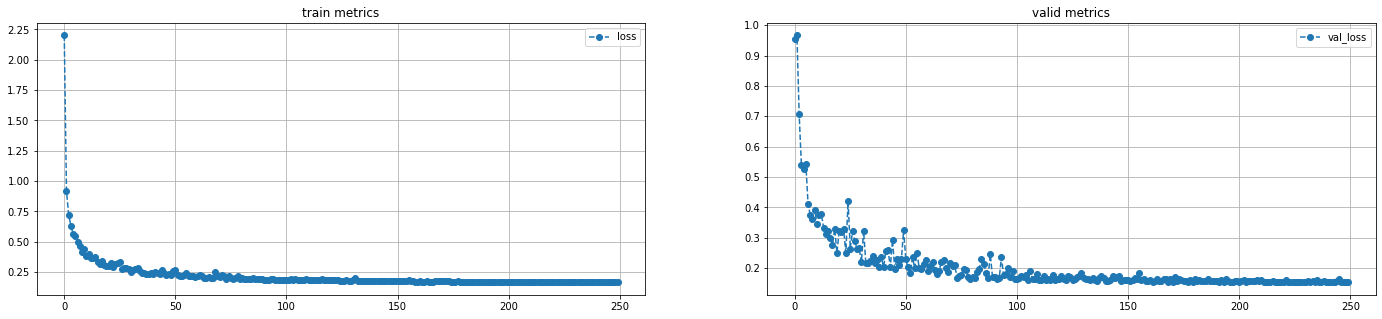

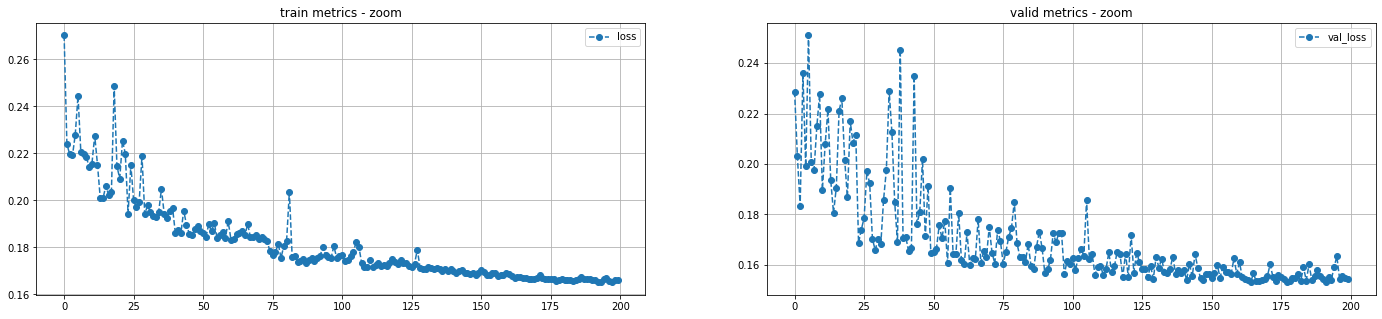

----------------------------------- Fold: 8 ------------------------------------
Epoch 1/300
133/133 [==============================] - 104s 377ms/step - loss: 1.7482 - val_loss: 0.8770
Epoch 2/300
133/133 [==============================] - 13s 98ms/step - loss: 0.7908 - val_loss: 0.7049
Epoch 3/300
133/133 [==============================] - 13s 98ms/step - loss: 0.6506 - val_loss: 0.5766
Epoch 4/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5936 - val_loss: 0.4870
Epoch 5/300
133/133 [==============================] - 13s 99ms/step - loss: 0.4936 - val_loss: 0.4388
Epoch 6/300
133/133 [==============================] - 13s 98ms/step - loss: 0.4905 - val_loss: 0.4044
Epoch 7/300
133/133 [==============================] - 13s 99ms/step - loss: 0.4999 - val_loss: 0.3705
Epoch 8/300
133/133 [==============================] - 13s 98ms/step - loss: 0.4311 - val_loss: 0.3468
Epoch 9/300
133/133 [==============================] - 13s 99ms/step - loss: 0.3655 - val_los

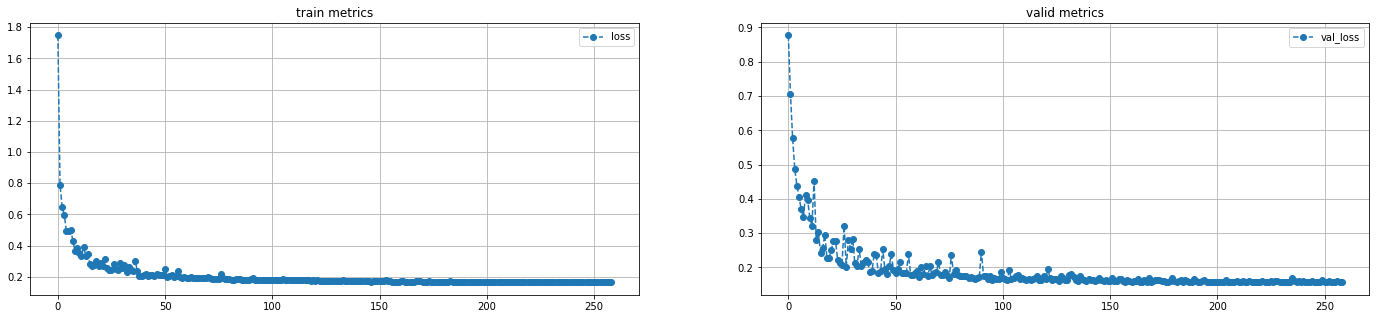

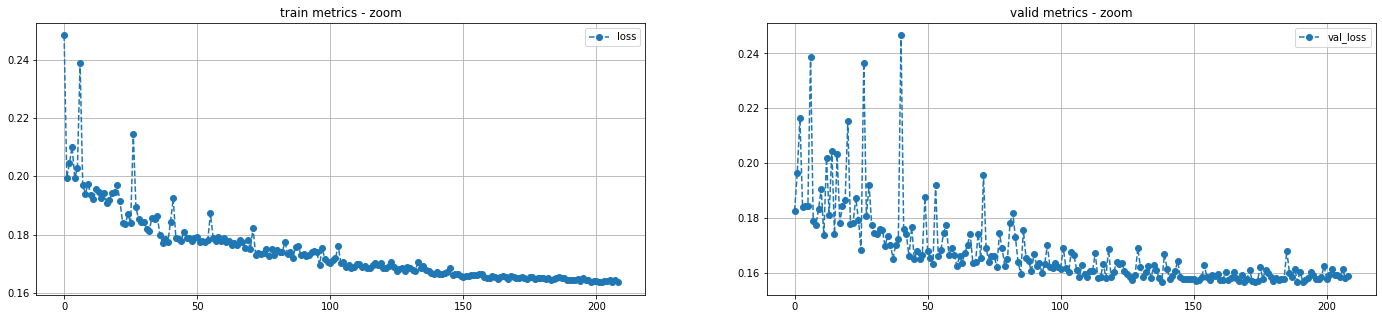

----------------------------------- Fold: 9 ------------------------------------
Epoch 1/300
133/133 [==============================] - 100s 378ms/step - loss: 1.9614 - val_loss: 0.7045
Epoch 2/300
133/133 [==============================] - 13s 99ms/step - loss: 0.7485 - val_loss: 1.0672
Epoch 3/300
133/133 [==============================] - 13s 99ms/step - loss: 0.6063 - val_loss: 0.7033
Epoch 4/300
133/133 [==============================] - 13s 100ms/step - loss: 0.5230 - val_loss: 0.5008
Epoch 5/300
133/133 [==============================] - 13s 100ms/step - loss: 0.4779 - val_loss: 0.4376
Epoch 6/300
133/133 [==============================] - 13s 100ms/step - loss: 0.4646 - val_loss: 0.4846
Epoch 7/300
133/133 [==============================] - 13s 99ms/step - loss: 0.4521 - val_loss: 0.4076
Epoch 8/300
133/133 [==============================] - 13s 100ms/step - loss: 0.4253 - val_loss: 0.3882
Epoch 9/300
133/133 [==============================] - 13s 100ms/step - loss: 0.4078 - va

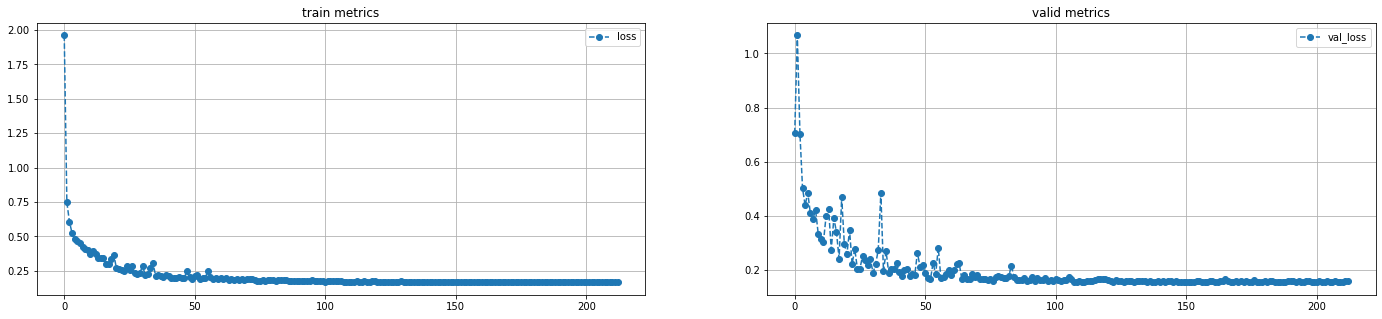

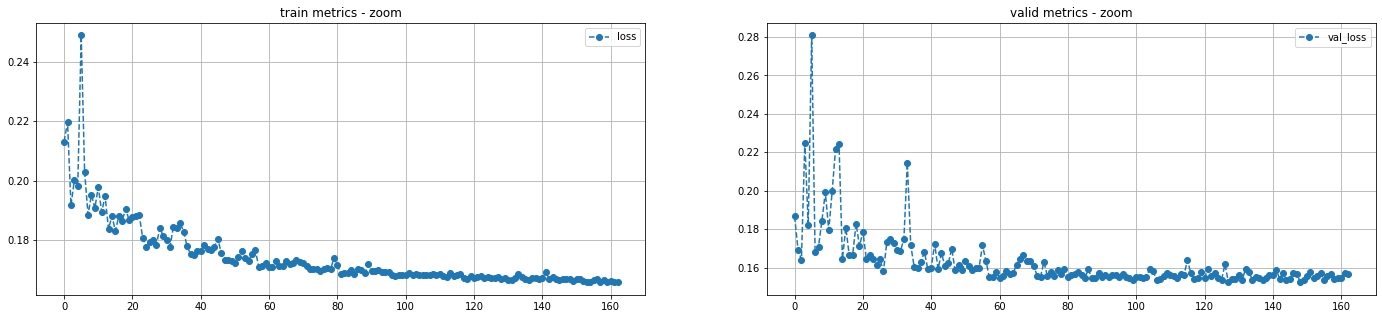

----------------------------------- Fold: 10 -----------------------------------
Epoch 1/300
133/133 [==============================] - 99s 375ms/step - loss: 2.3503 - val_loss: 0.9733
Epoch 2/300
133/133 [==============================] - 13s 98ms/step - loss: 0.8883 - val_loss: 0.8748
Epoch 3/300
133/133 [==============================] - 13s 98ms/step - loss: 0.7475 - val_loss: 0.7150
Epoch 4/300
133/133 [==============================] - 13s 98ms/step - loss: 0.6747 - val_loss: 0.6050
Epoch 5/300
133/133 [==============================] - 13s 98ms/step - loss: 0.6506 - val_loss: 0.6043
Epoch 6/300
133/133 [==============================] - 13s 98ms/step - loss: 0.6019 - val_loss: 0.5982
Epoch 7/300
133/133 [==============================] - 13s 98ms/step - loss: 0.5508 - val_loss: 0.5786
Epoch 8/300
133/133 [==============================] - 13s 98ms/step - loss: 0.5492 - val_loss: 0.6609
Epoch 9/300
133/133 [==============================] - 13s 99ms/step - loss: 0.5271 - val_loss

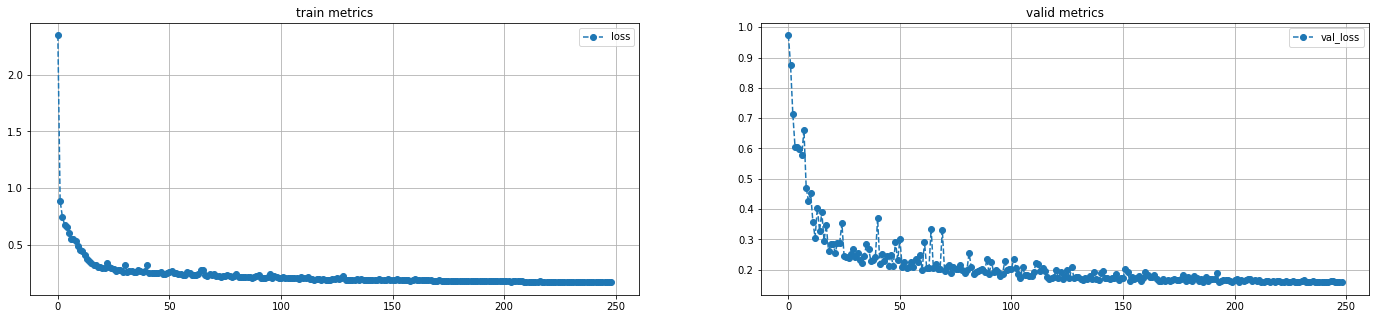

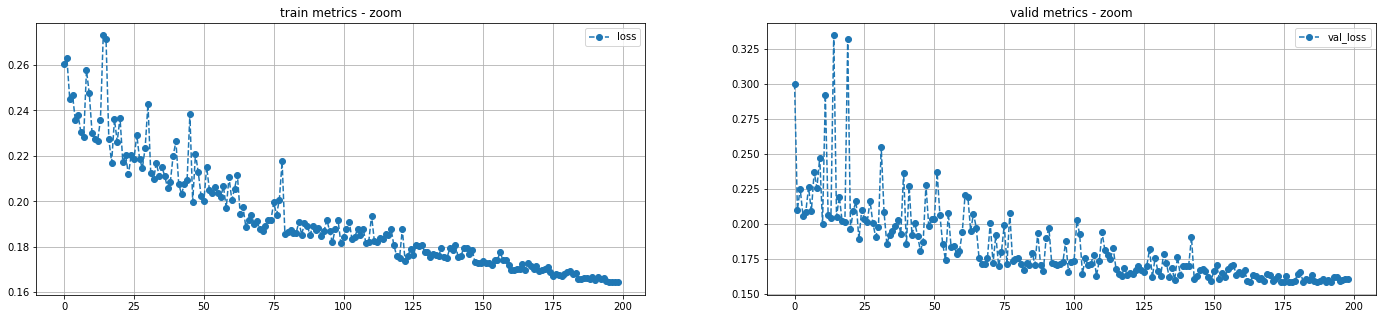

In [23]:
models_by_fold = list()

for fold in range(len(split)):
    print(f" Fold: {fold+1} ".center(80, "-"))
    
    train_idx = split[f"fold-{fold}"]["train"]
    valid_idx = split[f"fold-{fold}"]["valid"]

    X_train, X_valid = train[train_idx], train[valid_idx]
    y_train, y_valid = targets[train_idx], targets[valid_idx]

    mask_in_train, mask_in_valid = mask_in[train_idx], mask_in[valid_idx]
    mask_out_train, mask_out_valid = mask_out[train_idx], mask_out[valid_idx]

    model_path = f"{artifacts_path}/{config.MODEL_ID}_fold{fold}"

    if os.path.isdir(model_path):
        print("Found an already trained model!")
        with tpu_strategy.scope():
            model = LSTMGRU2Heads()
            load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
            model.load_weights(model_path, options=load_locally)
        do_train = False
    else:
        do_train = True

    if do_train:

        lr = ReduceLROnPlateau(
            monitor="val_loss", 
            factor=config.SCHEDULER_FACTOR, 
            patience=config.SCHEDULER_PATIENCE, 
            verbose=1,
            min_lr=1e-4,
            min_delta=0.0001,
        )
        es = EarlyStopping(
            monitor='val_loss', 
            mode='min', 
            patience=config.STOPPING_PATIENCE, 
            min_delta=0.0001,
            verbose=1,
            restore_best_weights=True,
        )

        with tpu_strategy.scope():
            model = LSTMGRU2Heads()
            optimizer = tf.optimizers.Adam(learning_rate=1e-3)
            model.compile(optimizer=optimizer,)

            history = model.fit(
                [X_train,mask_in_train,mask_out_train], 
                y_train, 
                validation_data=([X_valid,mask_in_valid,mask_out_valid], y_valid), 
                epochs=config.EPOCHS,
                batch_size=config.BATCH_SIZE, 
                callbacks=[es,lr],
                shuffle=True,
                verbose=1,
            )

        save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
        model.save_weights(model_path, options=save_locally, overwrite=True, save_format="tf")
        
        # metrics from epoch 0 ->
        plt.figure(figsize=(24,5))
        plt.subplot(1,2,1)
        plt.title("train metrics")
        plt.plot(history.history["loss"], "o--", label="loss")
        #plt.plot(history.history["mae_in"], "o--", label="mae_in")
        #plt.plot(history.history["mae_out"], "o--", label="mae_out")
        plt.grid()
        plt.legend(loc="best")

        plt.subplot(1,2,2)
        plt.title("valid metrics")
        plt.plot(history.history["val_loss"], "o--", label="val_loss")
        #plt.plot(history.history["val_mae_in"], "o--", label="val_mae_in")
        #plt.plot(history.history["val_mae_out"], "o--", label="val_mae_out")
        plt.grid()
        plt.legend(loc="best")
        plt.show()

        # metrics from epoch 50 ->
        plt.figure(figsize=(24,5))
        plt.subplot(1,2,1)
        plt.title("train metrics - zoom")
        plt.plot(history.history["loss"][50:], "o--", label="loss")
        #plt.plot(history.history["mae_in"][50:], "o--", label="mae_in")
        #plt.plot(history.history["mae_out"][50:], "o--", label="mae_out")
        plt.grid()
        plt.legend(loc="best")

        plt.subplot(1,2,2)
        plt.title("valid metrics - zoom")
        plt.plot(history.history["val_loss"][50:], "o--", label="val_loss")
        #plt.plot(history.history["val_mae_in"][50:], "o--", label="val_mae_in")
        #plt.plot(history.history["val_mae_out"][50:], "o--", label="val_mae_out")
        plt.grid()
        plt.legend(loc="best")
        plt.show()
    
    # generate the oof predictions
    oof_preds = model(tf.convert_to_tensor(X_valid)).numpy().squeeze()
    idx = oof.query("breath_id in @valid_idx").index
    oof.loc[idx, "pred"] = oof_preds.ravel()
    
    models_by_fold.append(model)

In [24]:
print("mae:", oof.eval("abs(pressure - pred)").mean())
print("mae inspiratory:", oof.query("u_out == 0").eval("abs(pressure - pred)").mean())
print("mae expiratory :", oof.query("u_out == 1").eval("abs(pressure - pred)").mean())

mae: 0.32267600297927856
mae inspiratory: 0.15364213287830353
mae expiratory : 3.469552516937256


***
## sub generation

In [25]:
all_preds = list()
test_tf = tf.convert_to_tensor(test, dtype=tf.float32)

for model in tqdm(models_by_fold):
    preds = model(test_tf).numpy().squeeze().ravel()
    all_preds.append(preds)

test_raw["pressure"] = np.median(all_preds, axis=0)

100%|██████████| 10/10 [12:10<00:00, 73.04s/it]


In [26]:
# saves final sub
sub = pd.merge(submission["id"], test_raw[["id","pressure"]], how="left", on="id")
sub["pressure"] = sub["pressure"].fillna(0)
sub.to_csv(f"{subs_path}/sub_{config.MODEL_ID}.csv", index=False)

sub["pressure"] =\
    np.round( (sub.pressure - PRESSURE_MIN)/PRESSURE_STEP ) * PRESSURE_STEP + PRESSURE_MIN
sub.pressure = np.clip(sub.pressure, PRESSURE_MIN, PRESSURE_MAX)
sub.to_csv(f"{subs_path}/sub_{config.MODEL_ID}_clip.csv", index=False)

In [27]:
# saves oof preds
oof.to_csv(f"{results_path}/oof_{config.MODEL_ID}.csv", index=False)

In [28]:
# saves each model preds (pseudo labels)
for fold,preds in enumerate(all_preds):
    file_path = f"{results_path}/predictions_{config.MODEL_ID}_{fold}.csv"
    if os.path.isfile(file_path):
        continue
    _sub = submission.copy()
    _test = test_raw[["id","pressure"]].copy()
    _test["pressure"] = preds
    _sub = pd.merge(_sub["id"], _test[["id","pressure"]], how="left", on="id")
    _sub["pressure"] = _sub["pressure"].fillna(0)
    _sub.to_csv(file_path, index=False)

***